Found 8 split directories

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   split_num     24 non-null     int64  
 1   set           24 non-null     object 
 2   samples       24 non-null     int64  
 3   positive_pct  24 non-null     float64
 4   features      24 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.1+ KB
None

DataFrame Head:
   split_num    set  samples  positive_pct  features
0          0  train      126     26.984127        49
1          0    val       40      2.500000        49
2          0   test       44     20.454545        49
3          1  train      124     20.967742        49
4          1    val       44     20.454545        49

DataFrame Columns:
['split_num', 'set', 'samples', 'positive_pct', 'features']

DataFrame Shape:
(24, 5)

Plotting DataFrame Info:
<class 'pandas.core.

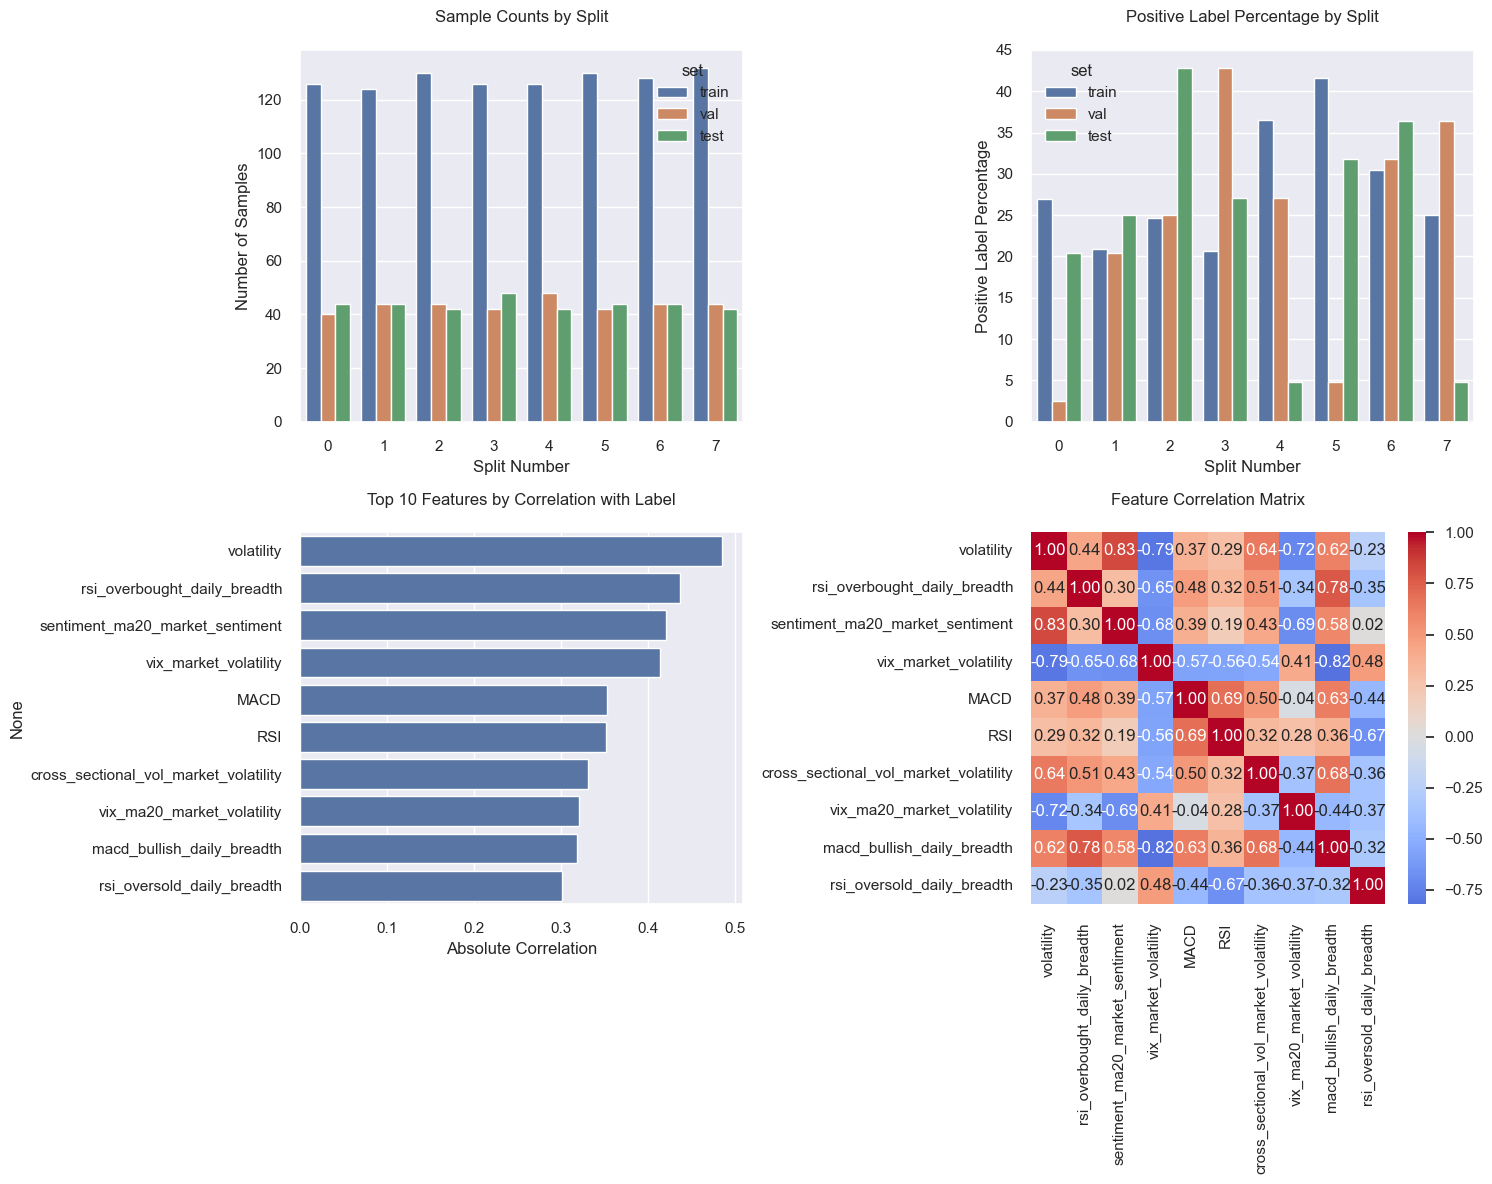


Dataset Summary:
Total splits: 8

Average samples per split:
set
test      43.75
train    127.75
val       43.50
Name: samples, dtype: float64

Label distribution range:
         min    max   mean
set                       
test    4.76  42.86  24.14
train  20.63  41.54  28.34
val     2.50  42.86  23.85


In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set_theme()

def load_split(split_num):
    """Load all datasets for a given split."""
    base_path = Path('../data/ml_datasets') / f'split_{split_num}'
    return {
        'train': pd.read_parquet(base_path / 'train.parquet'),
        'val': pd.read_parquet(base_path / 'val.parquet'),
        'test': pd.read_parquet(base_path / 'test.parquet')
    }

# Load and analyze all splits
def analyze_all_splits():
    """Analyze all splits in the dataset."""
    # Get all split directories
    split_dirs = sorted(Path('../data/ml_datasets').glob('split_*'))
    
    # Check if we found any splits
    if not split_dirs:
        print("No split directories found in ../data/ml_datasets/")
        print("Current directory structure:")
        print("Contents of ../data/ml_datasets/:")
        for item in Path('../data/ml_datasets').iterdir():
            print(f"  {item.name}")
        return pd.DataFrame(columns=['split_num', 'set', 'samples', 'positive_pct', 'features'])
    
    print(f"Found {len(split_dirs)} split directories")
    
    # Initialize results storage
    split_stats = []
    
    # Analyze each split
    for split_dir in split_dirs:
        try:
            split_num = int(split_dir.name.split('_')[1])
            split_data = load_split(split_num)
            
            # Store statistics
            for name, data in split_data.items():
                stats = {
                    'split_num': split_num,
                    'set': name,
                    'samples': len(data),
                    'positive_pct': data['label'].mean() * 100,
                    'features': len(data.columns)
                }
                split_stats.append(stats)
        except Exception as e:
            print(f"Error processing split {split_dir}: {str(e)}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(split_stats)
    
    # Print detailed DataFrame information
    print("\nDataFrame Info:")
    print(df.info())
    print("\nDataFrame Head:")
    print(df.head())
    print("\nDataFrame Columns:")
    print(df.columns.tolist())
    print("\nDataFrame Shape:")
    print(df.shape)
    
    return df

# Plot split statistics
def plot_split_statistics(stats_df):
    """Plot statistics across all splits."""
    if stats_df.empty:
        print("No data to plot - DataFrame is empty")
        return None
    
    # Print DataFrame info before plotting
    print("\nPlotting DataFrame Info:")
    print(stats_df.info())
    print("\nPlotting DataFrame Head:")
    print(stats_df.head())
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Sample counts
    sns.barplot(data=stats_df, x='split_num', y='samples', hue='set', ax=axes[0,0])
    axes[0,0].set_title('Sample Counts by Split', pad=20)
    axes[0,0].set_xlabel('Split Number')
    axes[0,0].set_ylabel('Number of Samples')
    
    # Positive label percentage
    sns.barplot(data=stats_df, x='split_num', y='positive_pct', hue='set', ax=axes[0,1])
    axes[0,1].set_title('Positive Label Percentage by Split', pad=20)
    axes[0,1].set_xlabel('Split Number')
    axes[0,1].set_ylabel('Positive Label Percentage')
    
    # Feature correlations for first split
    first_split_train = load_split(0)['train']
    
    # Select only numeric columns for correlation
    numeric_cols = first_split_train.select_dtypes(include=[np.number]).columns
    correlations = first_split_train[numeric_cols].corr()['label'].abs().sort_values(ascending=False)
    top_features = correlations[1:11]  # Top 10 features
    
    sns.barplot(x=top_features.values, y=top_features.index, ax=axes[1,0])
    axes[1,0].set_title('Top 10 Features by Correlation with Label', pad=20)
    axes[1,0].set_xlabel('Absolute Correlation')
    
    # Feature correlation matrix
    sns.heatmap(first_split_train[top_features.index].corr(), 
                annot=True, cmap='coolwarm', center=0, ax=axes[1,1],
                fmt='.2f')
    axes[1,1].set_title('Feature Correlation Matrix', pad=20)
    
    # Adjust layout
    plt.tight_layout()
    return fig

# Run analysis
stats_df = analyze_all_splits()
if not stats_df.empty:
    plot_split_statistics(stats_df)
    plt.show()

    # Print summary statistics
    print("\nDataset Summary:")
    print(f"Total splits: {len(stats_df['split_num'].unique())}")
    print(f"\nAverage samples per split:")
    print(stats_df.groupby('set')['samples'].mean().round(2))
    print("\nLabel distribution range:")
    print(stats_df.groupby('set')['positive_pct'].agg(['min', 'max', 'mean']).round(2))

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path

def examine_split(split_num=0):
    """Examine the contents of a specific split in detail."""
    base_dir = Path("../data/ml_datasets")
    split_dir = base_dir / f"split_{split_num}"
    
    # Load all three datasets
    train_df = pd.read_parquet(split_dir / "train.parquet")
    val_df = pd.read_parquet(split_dir / "val.parquet")
    test_df = pd.read_parquet(split_dir / "test.parquet")
    
    print(f"\n=== Split {split_num} Overview ===")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Display feature information
    print("\n=== Feature Information ===")
    print(f"Total features: {len(train_df.columns)}")
    print("\nFeature types:")
    print(train_df.dtypes.value_counts())
    
    # Display a sample row with all its features
    print("\n=== Sample Row (First row from training set) ===")
    sample_row = train_df.iloc[0]
    print("\nBasic Information:")
    print(f"Ticker: {sample_row['ticker']}")
    print(f"Label: {sample_row['label']}")
    
    print("\nFeature Values:")
    # Format the output to be more readable
    for col in train_df.columns:
        if col not in ['ticker', 'label']:
            value = sample_row[col]
            if isinstance(value, (int, float)):
                print(f"{col}: {value:.4f}")
            else:
                print(f"{col}: {value}")
    
    # Display label distribution
    print("\n=== Label Distribution ===")
    for name, df in [("Training", train_df), ("Validation", val_df), ("Test", test_df)]:
        pos_pct = (df['label'] == 1).mean() * 100
        print(f"{name} set: {pos_pct:.1f}% positive labels")

# Example usage
examine_split(1)  # Examine split_0


=== Split 1 Overview ===
Training samples: 124
Validation samples: 44
Test samples: 44

=== Feature Information ===
Total features: 49

Feature types:
float64    43
int64       6
Name: count, dtype: int64

=== Sample Row (First row from training set) ===

Basic Information:
Ticker: 0.0
Label: 0.0

Feature Values:
Open: 170.7935
High: 171.6082
Low: 169.1250
Close: 171.3824
Volume: 86213900.0000
RSI: 58.3641
MACD: -0.8071
MACD_Signal: -1.2729
MACD_Hist: 0.4657
BB_Upper: 178.3043
BB_Lower: 154.4128
BB_Middle: 166.3586
BB_Pband: 0.7103
SMA_20: 166.3586
SMA_50: 167.1967
SMA_100: 155.7252
SMA_200: 145.5435
EMA_100: 158.1586
EMA_200: 148.0216
adv_dec_line_daily_breadth: -6.0000
new_highs_daily_breadth: 29.0000
new_lows_daily_breadth: 22.0000
above_ma20_daily_breadth: 34.2052
above_ma50_daily_breadth: 30.1811
rsi_bullish_daily_breadth: 41.2475
rsi_oversold_daily_breadth: 1.2072
rsi_overbought_daily_breadth: 2.6157
macd_bullish_daily_breadth: 30.9859
vix_market_volatility: 21.9600
market_volat

In [55]:
base_dir = Path("../data/ml_datasets")
train_df = pd.read_parquet(base_dir / "split_0/train.parquet")
train_df.head()

,Open,High,Low,Close,Volume,RSI,MACD,MACD_Signal,MACD_Hist,BB_Upper,...,sentiment_zscore_market_sentiment,avg_tone_gdelt_raw,volatility,returns_1d,returns_5d,returns_20d,momentum_5d,momentum_20d,label,ticker
0,174.542917,179.499574,174.425140,178.645645,104487900,66.612977,4.739251,4.903560,-0.164309,180.232385,...,-0.778512,-2.043458,163.810254,-0.006180,-0.018658,0.037052,-0.003755,0.001938,0,0
1,179.254190,179.558457,175.809061,176.378342,99310400,61.914709,4.595140,4.841876,-0.246736,179.680505,...,-1.547340,-2.197719,160.862405,-0.009752,-0.021857,0.024720,-0.004403,0.001342,0,0
2,176.290001,176.839648,171.411868,171.686691,94537600,53.505117,4.055603,4.684621,-0.629018,179.506203,...,-1.100450,-2.142941,152.870807,-0.037234,-0.060212,-0.044927,-0.012261,-0.002168,0,0
3,169.507737,172.059683,168.467333,168.820679,96904000,49.116333,3.358044,4.419306,-1.061262,179.608857,...,-1.441949,-2.227293,152.746685,-0.000052,-0.055422,-0.053452,-0.011247,-0.002619,0,0
4,169.694241,170.921136,167.868622,168.987549,86709100,49.376699,2.786567,4.092758,-1.306191,179.684587,...,-1.143403,-2.193804,148.897928,-0.019083,-0.070644,-0.055864,-0.014460,-0.002744,0,0


In [56]:
train_df.iloc[0]

Open                                     1.745429e+02
High                                     1.794996e+02
Low                                      1.744251e+02
Close                                    1.786456e+02
Volume                                   1.044879e+08
RSI                                      6.661298e+01
MACD                                     4.739251e+00
MACD_Signal                              4.903560e+00
MACD_Hist                               -1.643087e-01
BB_Upper                                 1.802324e+02
BB_Lower                                 1.642600e+02
BB_Middle                                1.722462e+02
BB_Pband                                 9.006576e-01
SMA_20                                   1.722462e+02
SMA_50                                   1.596970e+02
SMA_100                                  1.520095e+02
SMA_200                                  1.413093e+02
EMA_100                                  1.542960e+02
EMA_200                     

In [54]:
train_df.label.unique()

array([1, 0])